#  PyTorch Paper Replicating
In this notebook we will be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

# 0. Getting Setup

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 255 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
#setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get Data

In [ ]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path/"train"
test_dir = image_path/"test"

## 1.1 Creating Dataloaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

IMG_SIZE = 224

data_transform = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               transform =data_transform,
                                                                               batch_size = 32)

## 1.2 Visualising a single image from the train_dataloader

(-0.5, 223.5, 223.5, -0.5)

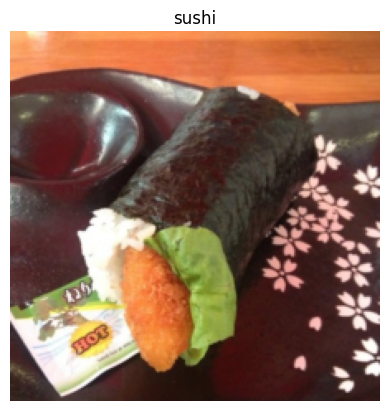

In [ ]:
import matplotlib.pyplot as plt

img, label = next(iter(train_dataloader))
img = img[0].permute(1,2,0)
plt.imshow(img)
plt.title(class_names[label[0]])
plt.axis(False)

# 2. Replicating ViT: Overview

## 2.1 ViT Overview: pieces of the puzzle

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```



---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---


**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

# 3. Equation 1: Split Data into patches and creating the class, position and patch embeddings

(-0.5, 223.5, 223.5, -0.5)

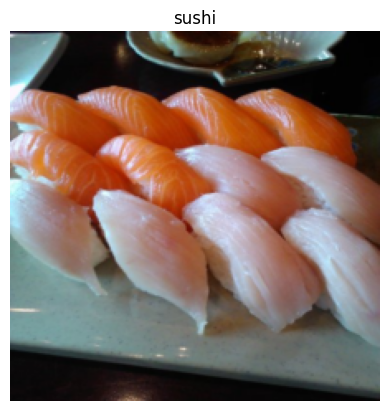

In [ ]:
img, label = next(iter(train_dataloader))
img = img[0].permute(1,2,0)
plt.imshow(img)
plt.title(class_names[label[0]])
plt.axis(False)

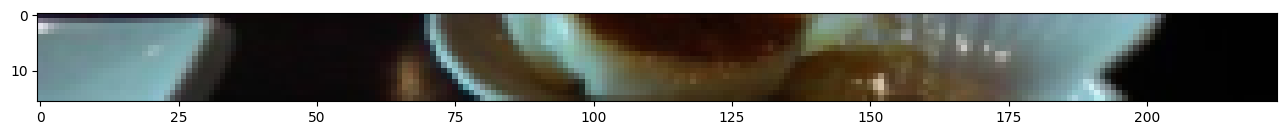

In [ ]:
#First let us see the top portion of the image and let us try to create patches of that
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img[:patch_size, :, :])

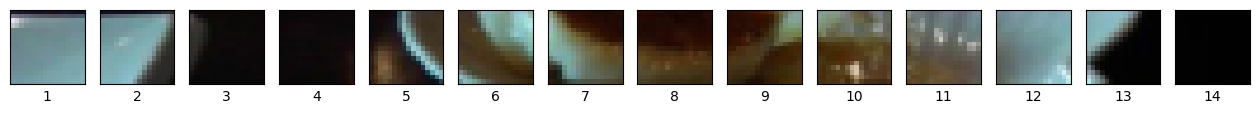

In [ ]:
img_size = 224
patch_size = 16
assert img_size%patch_size == 0, "Image size must be divisible by patch_size"

fig, axs = plt.subplots(nrows=1,
                        ncols =img_size // patch_size,
                        sharex= True,
                        sharey = True,
                        figsize = (patch_size,patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(img[:patch_size, patch:patch + patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Text(0.5, 0.98, 'sushi')

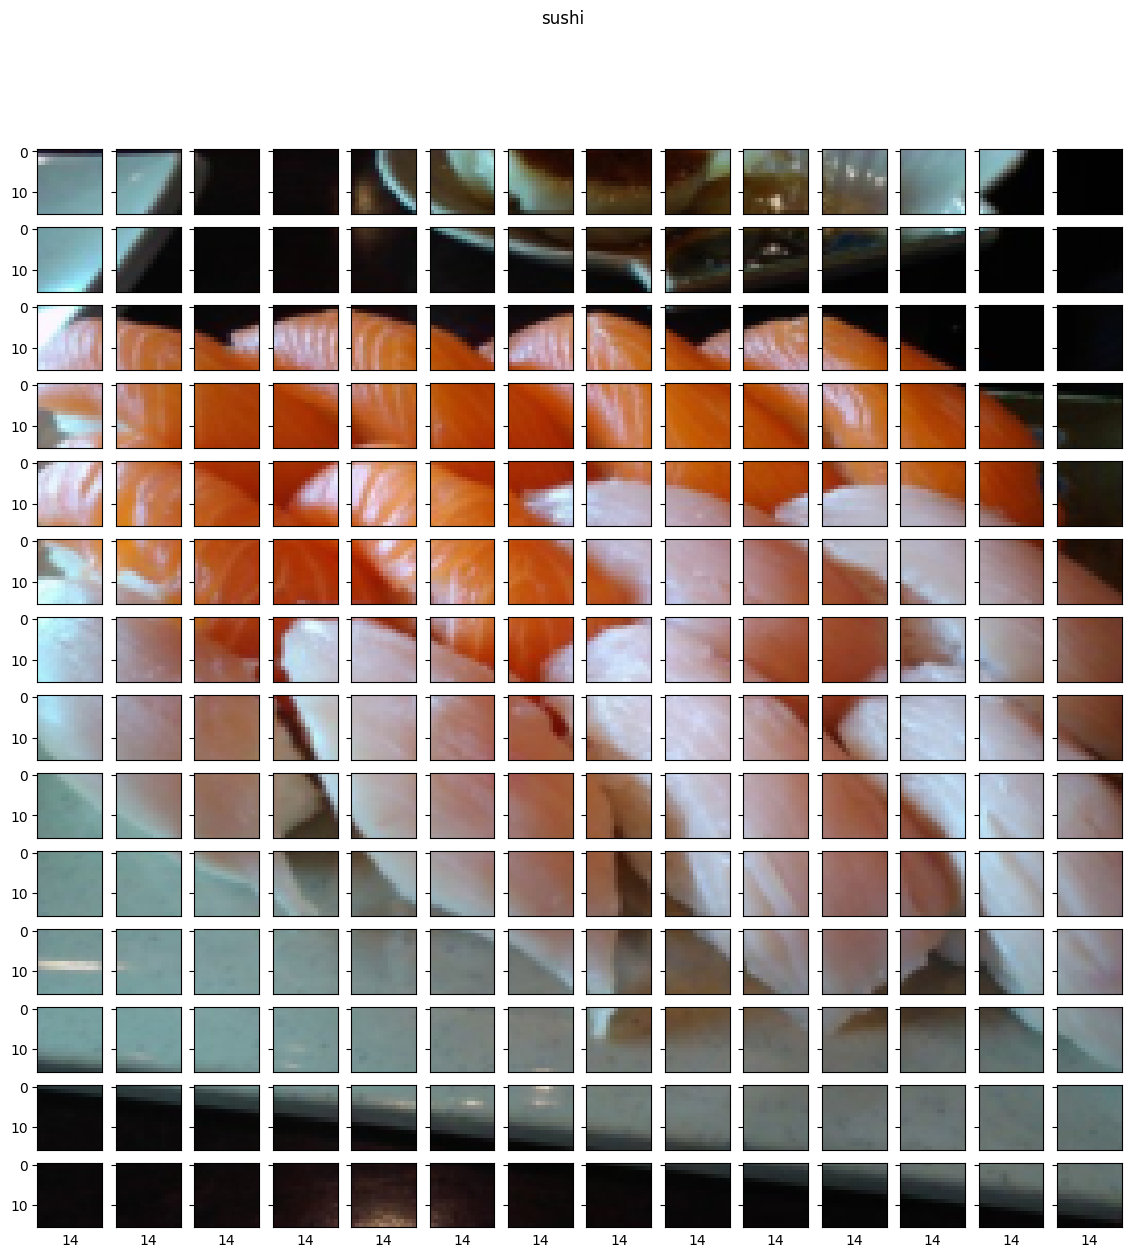

In [ ]:
#Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size%patch_size == 0, "Image size must be divisible by patch_size"

fig,axs = plt.subplots(nrows = img_size // patch_size,
                       ncols = img_size // patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True)
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i,j].imshow(img[patch_height : patch_height + patch_size, patch_width : patch_width + patch_size, :])
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_xlabel(i+1)
    axs[i,j].set_xticks([])
    axs[i,j].label_outer()


fig.suptitle(f"{class_names[label[0]]}")




## 3.1 Creating image patches and turning them into patch embeddings

In [ ]:
#Using Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels = 3,
                   out_channels=768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
img.shape

torch.Size([224, 224, 3])

In [ ]:
img = img.permute(2,0,1)

In [ ]:

img_out_of_conv = conv2d(img.unsqueeze(0))
img_out_of_conv.shape

torch.Size([1, 768, 14, 14])

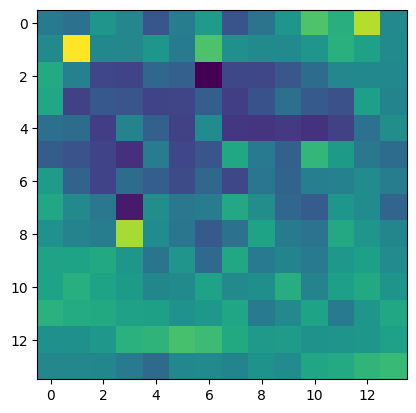

In [ ]:
#Visualizing a Convolutional Filter
sample = img_out_of_conv[:,500,:,:]
sample.squeeze(0)
plt.imshow(sample.permute(1,2,0).detach().numpy())

## 3.2 Flattening the patch embedding with `torch.nn.Flatten`


In [ ]:
img_out_of_conv.size()

torch.Size([1, 768, 14, 14])

In [ ]:
m = torch.nn.Flatten(2,3)
patch_embedding = m(img_out_of_conv)
patch_embedding.size()

torch.Size([1, 768, 196])

In [ ]:
patch_embedding_permuted = patch_embedding.permute(0,2,1)
patch_embedding_permuted

tensor([[[ 0.1822,  0.6531,  0.3716,  ..., -0.1664, -0.4532, -0.2607],
         [-0.0201,  0.5765,  0.2963,  ..., -0.1883, -0.3360, -0.1908],
         [ 0.0323,  0.0500, -0.0078,  ..., -0.0425, -0.1169,  0.0257],
         ...,
         [ 0.0070,  0.1524,  0.0586,  ..., -0.2372, -0.1928, -0.0662],
         [ 0.0542,  0.2516,  0.0856,  ..., -0.2269, -0.2482, -0.1336],
         [ 0.0817,  0.3106,  0.1298,  ..., -0.2003, -0.2902, -0.1593]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
train_dataloader

## 3.3 Turning the ViT patch embedding layer into a PyTorch Module

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
              in_channels : int,
              embedding_dim : int,
              patch_size : int
               ):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,
              out_channels = embedding_dim,
              kernel_size = patch_size,
              stride = patch_size,
              padding = 0)

    self.Flatten = nn.Flatten(start_dim = 2,end_dim = 3)

  def forward(self, x):
    x_patches = self.patcher(x)
    x_flattened = self.Flatten(x_patches)
    x_flattened_permuted = x_flattened.permute(0,2,1)
    return x_flattened_permuted


In [ ]:
img.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [ ]:
patchify = PatchEmbedding(in_channels = 3,
                          embedding_dim= 768,
                          patch_size = 16)

patch_embedded_image = patchify(img.unsqueeze(0))

patch_embedded_image.shape



torch.Size([1, 196, 768])

## 3.4 Creating the Class Token Embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.4194,  0.4573, -0.3829,  ...,  0.2110,  0.0289,  0.4977],
         [-0.3749,  0.3323, -0.3444,  ...,  0.3280, -0.0338,  0.4153],
         [-0.0954,  0.0095, -0.0112,  ..., -0.0671, -0.0137,  0.0500],
         ...,
         [-0.0586,  0.1978,  0.1632,  ...,  0.0352, -0.2010,  0.2209],
         [-0.1360,  0.2333,  0.1349,  ...,  0.0385, -0.1798,  0.2370],
         [-0.1641,  0.2500,  0.1036,  ...,  0.0149, -0.1877,  0.2973]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
embedding_dimension = patch_embedded_image.shape[-1]
embedding_dimension

768

In [ ]:
class_token = nn.Parameter(torch.ones(1,1,embedding_dimension))
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
x = torch.randn(2, 3)
y = torch.cat((x, x), 0)
z = torch.cat((x, x), 1)
print(f"{x.shape}")
print(f"{y.shape}")
print(f"{z.shape}")

torch.Size([2, 3])
torch.Size([4, 3])
torch.Size([2, 6])


In [ ]:
patched_image_with_class_embedding = torch.cat((class_token,patch_embedded_image), dim = 1)
patched_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
num_patches = img_size**2/patch_size**2
num_patches = int(num_patches)
num_patches

196

In [ ]:
embedding_dimension = patched_image_with_class_embedding.shape[-1]


In [ ]:
position_embedding = nn.Parameter(torch.ones(1,
                                             num_patches+1,
                                             embedding_dimension),
                                  requires_grad = True)
position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
patch_and_position_embedding = position_embedding + patched_image_with_class_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
row_values = torch.arange(0, 197)

repeated_values = row_values.unsqueeze(1).repeat(1, 768)

result = repeated_values.unsqueeze(0)

print(result.shape)
print(result)


torch.Size([1, 197, 768])
tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  2,   2,   2,  ...,   2,   2,   2],
         ...,
         [194, 194, 194,  ..., 194, 194, 194],
         [195, 195, 195,  ..., 195, 195, 195],
         [196, 196, 196,  ..., 196, 196, 196]]])


In [ ]:
patched_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4194,  0.4573, -0.3829,  ...,  0.2110,  0.0289,  0.4977],
         [-0.3749,  0.3323, -0.3444,  ...,  0.3280, -0.0338,  0.4153],
         ...,
         [-0.0586,  0.1978,  0.1632,  ...,  0.0352, -0.2010,  0.2209],
         [-0.1360,  0.2333,  0.1349,  ...,  0.0385, -0.1798,  0.2370],
         [-0.1641,  0.2500,  0.1036,  ...,  0.0149, -0.1877,  0.2973]]],
       grad_fn=<CatBackward0>)

In [ ]:
#Now we will add it to the patched image with class token. It also encodes the position of each and every patch.
patch_and_position_embedding = patched_image_with_class_embedding + result
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

## 3.5 Putting it all together: from Image to Embedding

In [ ]:
patch_size = 16
height, width = img.shape[1], img.shape[2]
X = img.unsqueeze(0)
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       embedding_dim = 768,
                                       patch_size = patch_size)
X_patched = patch_embedding_layer(X)
X_patched.shape

torch.Size([1, 196, 768])

In [ ]:
#Adding a learnable class token.
embedding_dimension = X_patched.shape[-1]
class_token = nn.Parameter(torch.ones(1,1,embedding_dimension), requires_grad = True)
X_class_embedding = torch.cat((class_token,patch_embedded_image), dim = 1)
X_class_embedding.shape


torch.Size([1, 197, 768])

In [ ]:
#Adding the Position Embedding.
num_patches = height*width/patch_size**2
A = nn.Parameter(torch.arange(0,197, dtype=torch.float32),requires_grad = True)
B = A.unsqueeze(1).repeat(1,768)
result = B.unsqueeze(0)
print(f"{result.shape}")
X_class_and_position_embeddded = result + X_class_embedding
print(f"{X_class_and_position_embeddded.shape}")



torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


# 4. Equation 2: MultiHead Self-Attention (MSA Block)

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """ Creates a multi-head Self Attention Block"""
  def __init__(self,
               embedding_dimension: int = 768,
               num_heads: int = 12,
               attn_dropout: int=0):
    super().__init__()
    # Creating the Norm-Layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dimension,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first=True)
  def forward(self,x):
    x = self.layer_norm(x)
    attn_output,_ = self.multihead_attn(query=x,
                                        key=x,
                                        value=x,
                                        need_weights = False)
    return attn_output

In [ ]:
Attn = MultiHeadSelfAttentionBlock(embedding_dimension=768,
                                   num_heads = 12,
                                   attn_dropout = 0
                                   )
X_output = Attn(X_class_and_position_embeddded)
X_output.shape

torch.Size([1, 197, 768])

In [ ]:
X_class_and_position_embeddded.shape

torch.Size([1, 197, 768])

# 5. Equation 3: MultiLayer Perceptron Block (MLP Block)

In [ ]:
#Start implementing the MultiLayer Perceptron Block
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: int = 0.1
               ):
    super().__init__()
    # embedding_dimension = attn_output.shape[-1]
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.MLP_layer = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size), #from the paper (Table 1)
        nn.GELU(),
        nn.Dropout(p = dropout,inplace = False),
        nn.Linear(in_features= mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p = dropout,inplace = False)
     )

  def forward(self, X):
    X = self.layer_norm(X)
    X_result = self.MLP_layer(X)
    return X_result

In [ ]:
mlp_block = MLPBlock()
X_result = mlp_block(X_output)

In [ ]:
print(X_class_and_position_embeddded)
print(X_output.shape)
print(X_result.shape)

tensor([[[  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
         [  0.5806,   1.4573,   0.6171,  ...,   1.2110,   1.0289,   1.4977],
         [  1.6251,   2.3323,   1.6556,  ...,   2.3280,   1.9662,   2.4153],
         ...,
         [193.9414, 194.1978, 194.1632,  ..., 194.0352, 193.7990, 194.2209],
         [194.8640, 195.2333, 195.1349,  ..., 195.0385, 194.8203, 195.2370],
         [195.8359, 196.2500, 196.1036,  ..., 196.0149, 195.8123, 196.2973]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [ ]:
X_result.shape

torch.Size([1, 197, 768])

#6. Creating the Transformer Encoder.
The Transformer Encoder is a combination of alternating blocks of MSA and MLP.

## 6.1) Creating a custom Transfer Encoder Layer

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads:int = 12,
               mlp_size: int = 3072,
               mlp_dropout: int = 0.1,
               attn_dropout: int = 0
               ):
    super().__init__()
    self.MSA_block = MultiHeadSelfAttentionBlock(embedding_dimension= embedding_dim,
                                             num_heads = num_heads,
                                             attn_dropout = attn_dropout).to(device)

    self.MLP_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout).to(device)
  def forward(self,X):
      msa_output = self.MSA_block(X) + X
      mlp_output = self.MLP_block(msa_output) + msa_output
      return mlp_output


In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (MSA_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (MLP_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (MLP_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

X_result = transformer_encoder_block(X_class_and_position_embeddded.to(device))
X_result.shape



torch.Size([1, 197, 768])

## 6.2)Creating a Transformer Encoder layer with in-built PyTorch Layers

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                       nhead = 12,
                                                       dim_feedforward = 3072,
                                                       dropout = 0.1,
                                                       activation = "gelu",
                                                       batch_first = True,
                                                       norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# 7. Putting it All Together to Create the Vision Transform (ViT):

In [ ]:
#Creating the ViT class
class ViT(nn.Module):
  def __init__(self,
             embedding_dim: int = 768,
             img_size: int = 224,
             in_channels:int = 3,
             patch_size: int = 16,
             num_transformer_layers: int = 12,
             num_heads:int = 12,
             mlp_size: int = 3072,
             attn_dropout: int = 0,
             mlp_dropout: int = 0.1,
             embedding_dropout: int = 0.1,   #Dropout for patch and position embedding
             num_classes : int = 1000
             ):
    super().__init__()
    #calculating the different values and creating the class and position embedding
    self.num_patches = int(img_size**2//patch_size**2)
    self.num_patches = int(self.num_patches)


    #creating the class embedding
    self.class_embedding = nn.Parameter(data = torch.randn(1,1,embedding_dim),
                                        requires_grad = True).to(device)

    #creating the position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1,self.num_patches+1, embedding_dim)).to(device)

    #setting the embedding dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout).to(device)

    #Creating the Patch Embedding Layer
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          embedding_dim= embedding_dim,
                                          patch_size = patch_size).to(device)
    #Creating the Transformer Encoder Block
    self.transformer_encoder_block = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                       num_heads= num_heads,
                                                                       mlp_size = mlp_size,
                                                                       mlp_dropout = mlp_dropout,
                                                                       ) for _ in range(num_transformer_layers)]).to(device)
    #Create Classifier Head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
        ).to(device)
  def forward(self,x):
    #First get the batch_size
    batch_size = x.shape[0]

    #Creating the class_token
    class_token = self.class_embedding.expand(batch_size,-1,-1)

    #Creating the patch_embedding of the input image
    x = self.patch_embedding(x)

    #concatenating the X_patch_embedding with the class_token
    x= torch.cat((x,class_token),dim = 1)

    #adding the position embedding with the X_class_embedding
    x = x + self.position_embedding

    #applying dropout to the patch_embedding
    x = self.embedding_dropout(x)

    #Putting X into the Transformer Layer.
    x = transformer_encoder_block(x)

    #Putting the 0th index via the classifier
    x = self.classifier(x[:,0])

    return x

In [ ]:
device

'cuda'

In [ ]:
vit = ViT(num_classes = 1000)
vit = vit.to(device)


In [ ]:
for layer in vit.children():
    if hasattr(layer, 'to'):
        layer.to(device)


In [ ]:
for name, param in vit.named_parameters():
    if param.device != torch.device('cuda'):
        print(f"Layer {name} is not on {torch.device('cuda')}, moving it now.")
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)


Layer patch_embedding.patcher.weight is not on cuda, moving it now.
Layer patch_embedding.patcher.bias is not on cuda, moving it now.
Layer transformer_encoder_block.0.MSA_block.layer_norm.weight is not on cuda, moving it now.
Layer transformer_encoder_block.0.MSA_block.layer_norm.bias is not on cuda, moving it now.
Layer transformer_encoder_block.0.MSA_block.multihead_attn.in_proj_weight is not on cuda, moving it now.
Layer transformer_encoder_block.0.MSA_block.multihead_attn.in_proj_bias is not on cuda, moving it now.
Layer transformer_encoder_block.0.MSA_block.multihead_attn.out_proj.weight is not on cuda, moving it now.
Layer transformer_encoder_block.0.MSA_block.multihead_attn.out_proj.bias is not on cuda, moving it now.
Layer transformer_encoder_block.0.MLP_block.layer_norm.weight is not on cuda, moving it now.
Layer transformer_encoder_block.0.MLP_block.layer_norm.bias is not on cuda, moving it now.
Layer transformer_encoder_block.0.MLP_block.MLP_layer.0.weight is not on cuda, m

In [ ]:
for name, param in vit.named_parameters():
    if param.device != device:
        print(f"Layer {name} is not on {device}")

Layer patch_embedding.patcher.weight is not on cuda
Layer patch_embedding.patcher.bias is not on cuda
Layer transformer_encoder_block.0.MSA_block.layer_norm.weight is not on cuda
Layer transformer_encoder_block.0.MSA_block.layer_norm.bias is not on cuda
Layer transformer_encoder_block.0.MSA_block.multihead_attn.in_proj_weight is not on cuda
Layer transformer_encoder_block.0.MSA_block.multihead_attn.in_proj_bias is not on cuda
Layer transformer_encoder_block.0.MSA_block.multihead_attn.out_proj.weight is not on cuda
Layer transformer_encoder_block.0.MSA_block.multihead_attn.out_proj.bias is not on cuda
Layer transformer_encoder_block.0.MLP_block.layer_norm.weight is not on cuda
Layer transformer_encoder_block.0.MLP_block.layer_norm.bias is not on cuda
Layer transformer_encoder_block.0.MLP_block.MLP_layer.0.weight is not on cuda
Layer transformer_encoder_block.0.MLP_block.MLP_layer.0.bias is not on cuda
Layer transformer_encoder_block.0.MLP_block.MLP_layer.3.weight is not on cuda
Layer tr

In [ ]:
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device = device)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                [1, 3, 224, 224]     [1, 1000]            85,054,464           True
├─PatchEmbedding (patch_embedding)       [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (Flatten)                 [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)            [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (classifier)                [1, 768]             [1, 1000]            --                   True
│    └─LayerNorm (0)                     [1, 768]             [1, 768]             1,536                True
│    └─Linear (1)                        [1, 768]             [1, 1000]            769,000              True
Total params: 86,4

# 8. Setting up Training code for our custom ViT

## 8.1 Setting up the Optimizer:
The paper states that it uses the Adam Optimizer.


In [ ]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr = 0.0001,
                             weight_decay = 0.1)

## 8.2 Setting up the Loss Function

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
device

'cuda'

## 8.3 Training our ViT Model.

In [ ]:
from going_modular.going_modular import engine
results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.3063 | train_acc: 0.0977 | test_loss: 5.2948 | test_acc: 0.1979
Epoch: 2 | train_loss: 4.4811 | train_acc: 0.4023 | test_loss: 3.9140 | test_acc: 0.1667
Epoch: 3 | train_loss: 3.3884 | train_acc: 0.2969 | test_loss: 3.1011 | test_acc: 0.1562
Epoch: 4 | train_loss: 2.7315 | train_acc: 0.3047 | test_loss: 2.5252 | test_acc: 0.1771
Epoch: 5 | train_loss: 2.1659 | train_acc: 0.2969 | test_loss: 2.1242 | test_acc: 0.1458
Epoch: 6 | train_loss: 2.1593 | train_acc: 0.4375 | test_loss: 2.0219 | test_acc: 0.1875
Epoch: 7 | train_loss: 1.9218 | train_acc: 0.3047 | test_loss: 1.9118 | test_acc: 0.1562
Epoch: 8 | train_loss: 1.9529 | train_acc: 0.3203 | test_loss: 1.7107 | test_acc: 0.2879
Epoch: 9 | train_loss: 1.7603 | train_acc: 0.4023 | test_loss: 1.6462 | test_acc: 0.3286
Epoch: 10 | train_loss: 1.5835 | train_acc: 0.4609 | test_loss: 1.6103 | test_acc: 0.1875
Epoch: 11 | train_loss: 1.5729 | train_acc: 0.3203 | test_loss: 1.6174 | test_acc: 0.1771
Epoch: 12 | train_l

KeyboardInterrupt: 

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 8.4 Why are we not getting a higher accuracy?
In the ViT paper the researchers train the ViT Transformer on large amounts of data and in total on around 318 Million images which is the reason behind how they achieve such high accuracies.
Now we will try to train our ViT model on the Food101 Dataset.


# 9. Training our ViT Transformer on the Food101 dataset.

## 9.1 Getting the Food101 Data

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32


data_transform = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
# Downloading and loading the Food101 dataset
food101_dataset = torchvision.datasets.Food101(root='food_101_data', split='train', download=True, transform=data_transform)


In [ ]:
len(food101_dataset)

In [ ]:
train_size = int(0.8*len(food101_dataset))
test_size = int(0.2*len(food101_dataset))

train_data, test_data = random_split(food101_dataset,[train_size,test_size])
len(test_data)

In [ ]:
class_names = food101_dataset.classes
len(class_names)

## 9.2 Creating the Train and Test Dataloader

In [ ]:
train_dataloader_food101 = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle= True)
test_dataloader_food101 = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle= False)

In [ ]:
import matplotlib.pyplot as plt

img, label = next(iter(train_dataloader_food101 ))
img = img[0].permute(1,2,0)
plt.imshow(img)
plt.title(class_names[label[0]])
plt.axis(False)

In [ ]:
img.shape

## 9.3 Training the ViT Transformer on the Food101 dataset.

In [ ]:
#Initalizing a new instance of ViT transformer
VIT = ViT(num_classes = 101)

In [ ]:
optimizer_1 = torch.optim.Adam(params = VIT.parameters(),
                             lr = 1e-3,
                             weight_decay = 0.1)

loss_fn_1 = nn.CrossEntropyLoss()

In [ ]:
#We will run this when we get the GPU!!!

from going_modular.going_modular import engine

optimizer = torch.optim.Adam(VIT.parameters(),
                             lr = 1e-3,
                             weight_decay = 0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model = VIT,
                       train_dataloader = train_dataloader_food101,
                       test_dataloader = test_dataloader_food101,
                       optimizer = optimizer_1,
                       loss_fn = loss_fn_1,
                       epochs = 10,
                       device = device)

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

# 10. Getting a PreTrained ViT from `torchvision.models`

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

pretrained_vit.parameters()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 71.3MB/s]


<generator object Module.parameters at 0x797c108eb680>

In [ ]:
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False


In [ ]:
#Modifying the classifier head for finetuning task.
pretrained_vit.heads = nn.Linear(in_features = 768,
                                 out_features = 3).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 10.1 Preparing the data for using it in the Pretrained Model:

In [ ]:
#Get the transforms used in the VIT base transform model.
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

IMG_SIZE = 224


train_dataloader_vit, test_dataloader_vit , class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               transform =vit_transforms,
                                                                               batch_size = 32)

In [ ]:
train_dataloader_vit

## 10.2 Fine-Tuning our Pretrained ViT Model

In [ ]:
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                             lr = 0.0001,
                             weight_decay = 0.1)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from going_modular.going_modular import engine

pretrained_vit_results = engine.train(model = pretrained_vit,
                       train_dataloader = train_dataloader_vit,
                       test_dataloader = test_dataloader_vit,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0324 | train_acc: 0.4609 | test_loss: 0.9865 | test_acc: 0.5568
Epoch: 2 | train_loss: 0.9572 | train_acc: 0.6250 | test_loss: 0.9188 | test_acc: 0.6610
Epoch: 3 | train_loss: 0.8989 | train_acc: 0.7031 | test_loss: 0.8574 | test_acc: 0.7538
Epoch: 4 | train_loss: 0.8473 | train_acc: 0.6602 | test_loss: 0.8029 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7643 | train_acc: 0.8203 | test_loss: 0.7497 | test_acc: 0.8049
Epoch: 6 | train_loss: 0.7315 | train_acc: 0.7305 | test_loss: 0.6993 | test_acc: 0.8456
Epoch: 7 | train_loss: 0.6540 | train_acc: 0.8867 | test_loss: 0.6561 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.7427 | train_acc: 0.7734 | test_loss: 0.6239 | test_acc: 0.8561
Epoch: 9 | train_loss: 0.5746 | train_acc: 0.9180 | test_loss: 0.6005 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.5601 | train_acc: 0.9297 | test_loss: 0.5764 | test_acc: 0.8769
Epoch: 11 | train_loss: 0.5229 | train_acc: 0.9297 | test_loss: 0.5543 | test_acc: 0.8769
Epoch: 12 | train_l

In [ ]:
from PIL import Image

In [ ]:
image_path = "/content/download (1).jfif"  # Replace with your actual image path
image = Image.open(image_path)


# Apply the transform
transformed_image = vit_transforms(image)

In [ ]:
y = pretrained_vit(transformed_image.unsqueeze(0).to(device))
print(f"This is an image of {class_names[torch.argmax(y)]}")

This is an image of pizza


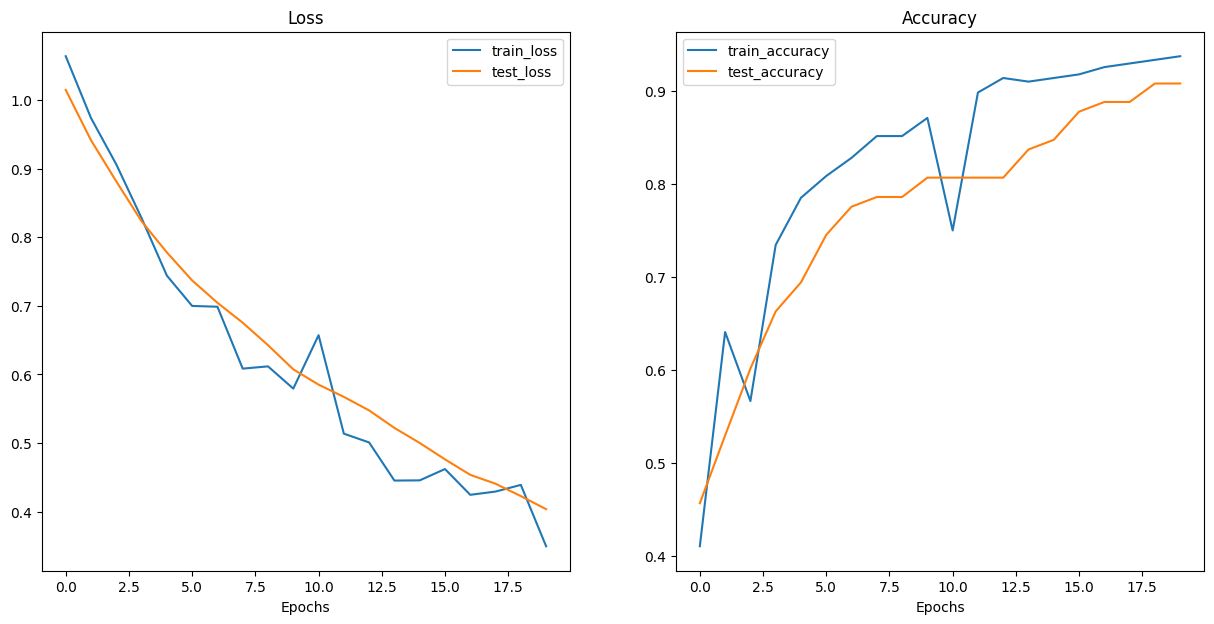

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")


Pretrained ViT feature extractor model size: 327 MB
